# Zivich et al. (2022): Delicatessen Publication

The following is the code to replicate the examples provided in Zivich et al. (2022). These examples are some common use cases of M-estimation in life science research. Specifically, we provide three case studies.

Zivich PN, Klose M, Cole SR, Edwards JK, & Shook-Sa BE. (2022). Delicatessen: M-Estimation in Python. arXiv preprint arXiv:2203.11300.

## Setup

In [1]:
# Loading packages for examples
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 300

import delicatessen
from delicatessen import MEstimator
from delicatessen.data import load_robust_regress, load_inderjit
from delicatessen.estimating_equations import (ee_regression, 
                                               ee_robust_regression,
                                               ee_loglogistic, 
                                               ee_loglogistic_ed)
from delicatessen.utilities import inverse_logit

decimal_places = 3
np.random.seed(51520837)

print("NumPy version:       ", np.__version__)
print("SciPy version:       ", sp.__version__)
print("Pandas version:      ", pd.__version__)
print("Matplotlib version:  ", matplotlib.__version__)
print("Delicatessen version:", delicatessen.__version__)

NumPy version:        1.25.2
SciPy version:        1.11.2
Pandas version:       1.4.1
Matplotlib version:   3.5.1
Delicatessen version: 2.3


## Case Study 1: Linear Regression

The first example considers application of linear regression with an outlier. We will use some simulated data to compare simple linear regression to robust linear regression.

### Benchmark

Since the outlier was simulated, we will first load the data and use simple linear regression as a benchmark. The following block of code implements this

In [2]:
# Loading the data without the outlier to generate reference
d = load_robust_regress(outlier=False)       # Loads data without outlier
x = d[:, 0]                                  # Extract X-values (height)
y = d[:, 1]                                  # Extract Y-values (weight)
X = np.vstack((np.ones(x.shape[0]), x)).T    # Convert to array


def psi_simple_linear(theta):
    return ee_regression(theta=theta, 
                         X=X, 
                         y=y, 
                         model='linear')


# Linear regression without the outlier for reference
lme = MEstimator(psi_simple_linear, 
                 init=[0., 0.])
lme.estimate(solver='hybr')

Now we can load the data with the outlier and reuse the defined estimating equation above to estimate the simple linear regression model

In [3]:
# Loading the data with the outlier
d = load_robust_regress(outlier=True)       # Loads data with outlier
y = d[:, 1]                                 # Extract Y with outlier

# Linear regression with the outlier
ulme = MEstimator(psi_simple_linear, 
                  init=[0., 0.])
ulme.estimate(solver='hybr')

Finally, robust linear regression is used with the Huber method

In [4]:
def psi_case1_robust(theta):
    return ee_robust_regression(theta=theta, 
                                X=X, 
                                y=y, 
                                k=1.345, 
                                model='linear')


# Notice: the theta from the previous regression is used since
#   robust regression can fail when initial values are too far.
rlme = MEstimator(psi_case1_robust, 
                  init=ulme.theta)
rlme.estimate(solver='hybr')

To distinguish between our results, we will generate a figure of the three estimated regression lines

C:\Users\zivic\AppData\Local\Temp\ipykernel_23876\1702613546.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.arrow(159.386, float(y[x == 159.386]) - 2.75, 0, 2.1,


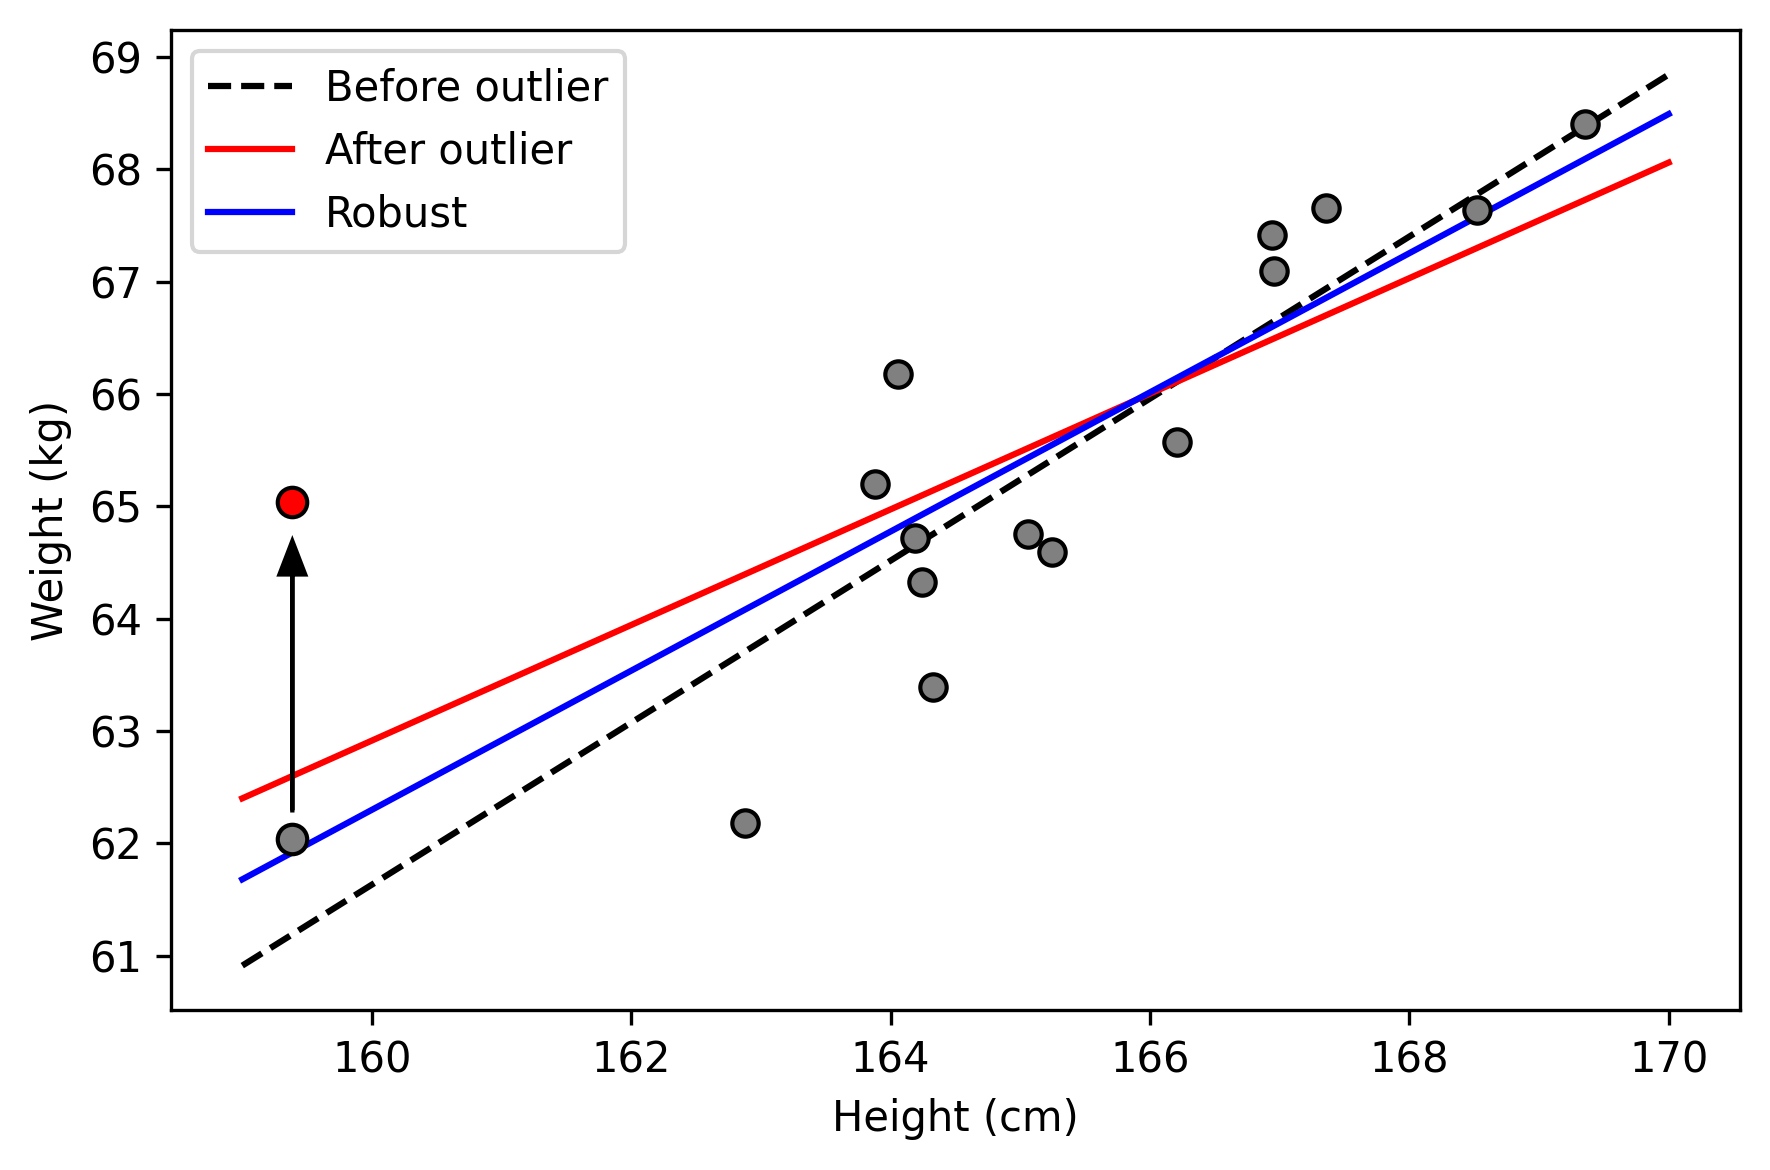

In [5]:
# Displaying results
plt.figure(figsize=[6, 4])

xlin = np.linspace(159, 170, 100)

# Plotting linear model results
plt.plot(xlin, lme.theta[0] + xlin*lme.theta[1],
         '--', color='k', label='Before outlier')
plt.plot(xlin, ulme.theta[0] + xlin*ulme.theta[1],
         '-', color='red', label='After outlier')
plt.plot(xlin, rlme.theta[0] + xlin*rlme.theta[1],
         '-', color='blue', label='Robust')

# Plotting the data points (including the outlier)
plt.scatter(x, y, s=40, c='gray', edgecolors='k', 
            label=None, zorder=4)
plt.scatter(159.386, y[x == 159.386] - 3, s=50, c='gray', 
            edgecolors='k', zorder=4)
plt.scatter(159.386, y[x == 159.386], s=50, c='red', 
            edgecolors='k', zorder=5)
plt.arrow(159.386, float(y[x == 159.386]) - 2.75, 0, 2.1, 
          head_width=0.2, facecolor='k', zorder=5)

# Making nice labels for graph
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.legend()

# Outputting result
plt.tight_layout()

As seen, the simple linear regression model is sensitive to the outlier. Robust linear regression is less sensitive (and is closer to the benchmark, the dashed line).


## Case Study 2: Dose-Response Curve

Next, we consider estimation of the dose-response curve using some publicly available data that come pre-packaged with `delicatessen`.

In [6]:
d = load_inderjit()

The following code implements a 3-parameter log-logistic model (the lower limit is set to zero, i.e., it is not estimated). Additionally, we append an estimating equation to compute the 20% effective dose.

In [7]:
def psi(theta):
    # Asserting that the lower limit is zero
    lower_limit = 0

    # Estimating equations for the 3PL model
    pl3 = ee_loglogistic(theta=[lower_limit, ] + list(theta[:3]), 
                         dose=d[:, 1], response=d[:, 0])

    # Estimating equations for the effective concentrations
    ed20 = ee_loglogistic_ed(theta[3], dose=d[:, 1], delta=0.20,
                             lower=lower_limit, upper=theta[0],
                             steepness=theta[2], ed50=theta[1])

    # Returning stacked estimating equations
    return np.vstack((pl3[1:, :],
                      ed20))



# Optimization procedure
mest = MEstimator(psi, init=[8., 3, 2., 2.])
mest.estimate(solver='lm')
ci_theta = mest.confidence_intervals()

In [8]:
# Printing the results to the console
print("==================================")
print("Case Study 2: Results")
print("==================================")
print("ED(50)")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[0], decimal_places))
print("95% CI:", np.round(ci_theta[0],
                          decimal_places))
print("----------------------------------")
print("Steepness")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[1], decimal_places))
print("95% CI:", np.round(ci_theta[1],
                          decimal_places))
print("----------------------------------")
print("Upper Limit")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[2], decimal_places))
print("95% CI:", np.round(ci_theta[2],
                          decimal_places))
print("----------------------------------")
print("ED(20)")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[3], decimal_places))
print("95% CI:", np.round(ci_theta[3],
                          decimal_places))
print("=========================================")

Case Study 2: Results
ED(50)
----------------------------------
Est:    7.855
95% CI: [7.554 8.157]
----------------------------------
Steepness
----------------------------------
Est:    3.263
95% CI: [2.743 3.784]
----------------------------------
Upper Limit
----------------------------------
Est:    2.47
95% CI: [1.897 3.043]
----------------------------------
ED(20)
----------------------------------
Est:    1.862
95% CI: [1.581 2.143]


The results can also be shown through a visualization of the estimated dose-response function. 

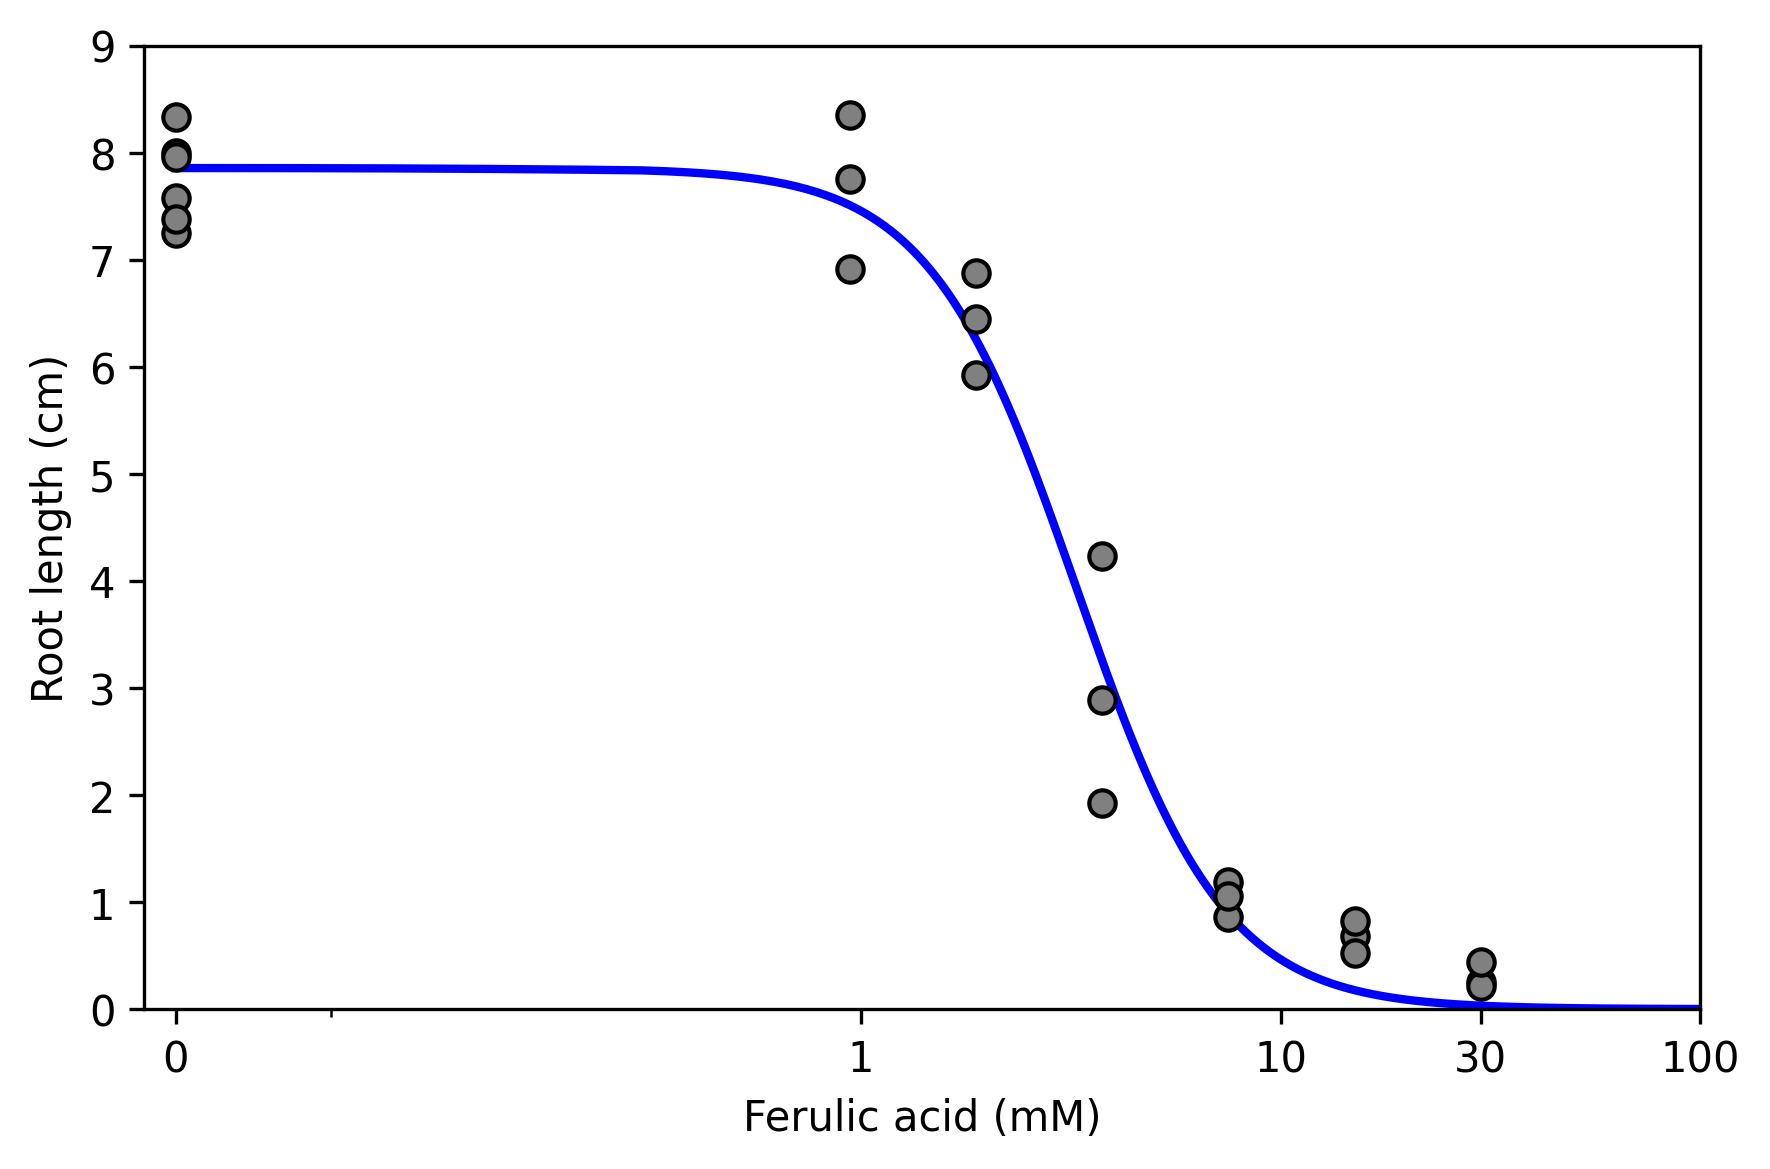

In [9]:
# Displaying results
plt.figure(figsize=[6, 4])

x = np.linspace(0, 100, 5000)
theta = mest.theta
y = 0 + (theta[0] - 0) / (1 + (x/theta[1])**theta[2])

# Plotting points and drawing dose-response line
plt.plot(x, y, '-', color='blue', linewidth=2)
plt.scatter(d[:, 1], d[:, 0], s=40, c='gray', edgecolors='k', zorder=5)

plt.ylim([0, 9])
plt.ylabel("Root length (cm)")
plt.xscale('symlog', linthresh=0.3)
plt.xlim([-0.02, 100])
plt.xticks([0, 1, 10, 30, 100],
           ["0", "1", "10", "30", "100"])
plt.xlabel("Ferulic acid (mM)")
plt.tight_layout()

As we can see here, the higher the dose, the shorter the root length.

## Case Study 3: Standardization to external population

For the final example, we use inverse odds weights to standardize scientific results to an external population by drug use. This approach helps to generalize study results beyond a particular convenience sample

In [10]:
# Loading Kamat et al. 2012
d1 = pd.read_csv("data/kamat.et.al.2012_biomarkers.csv")
d1['drug_use'] = np.where(d1['Cocaine'] + d1['Opiate'] > 0, 1, 0)
d1['S'] = 1
biomarkers = ['IFN_alpha', 'CXCL9', 'CXCL10', 'sIL-2R', 'IL12']
d1 = d1[['drug_use', 'S', ] + biomarkers].copy()
for bm in biomarkers:
    d1[bm] = np.log(d1[bm])


# MACS/ WIHS in 2018-2019 of cocaine or heroin use in previous 6 months
d0 = pd.DataFrame()
d0['drug_use'] = [1]*300 + [0]*(4016-300)
d0['S'] = 0


# Stacking data together and adding constant for model
d = pd.concat([d0, d1])           # Stacking data sets together
d['constant'] = 1                 # Creating intercept for the model
d[biomarkers] = d[biomarkers].fillna(9999)

The following code calculates the means for the study population. Note that these may not be generalizable

In [11]:
def psi_standard_mean(theta):
    # Returning stacked estimating equations
    return (np.asarray(d1['IFN_alpha']) - theta[0],
            np.asarray(d1['CXCL9']) - theta[1],
            np.asarray(d1['CXCL10']) - theta[2],
            np.asarray(d1['sIL-2R']) - theta[3],
            np.asarray(d1['IL12']) - theta[4], )


nm = MEstimator(psi_standard_mean, init=[1., ]*5)
nm.estimate()

The following code generalizes the results from Kamat et al. using data from the Women's Interagency HIV Study (WIHS). The WIHS study is considered to be more generalizable, but we don't have access to these biomarkers in the WIHS data. 

In [12]:
# Weighted means to standardize to population
x = np.asarray(d[['constant', 'drug_use']])
s = np.asarray(d['S'])


def psi_weighted_mean(theta):
    global x, y, s

    # Estimating weights
    nuisance = ee_regression(theta=theta[:2],
                             X=x, y=s, model='logistic')
    pi = inverse_logit(np.dot(x, theta[:2]))
    weight = np.where(s == 1, (1-pi)/pi, 0)

    # Returning stacked estimating equations
    return np.vstack((nuisance,
                      s*weight*(np.asarray(d['IFN_alpha']) - theta[2]),
                      s*weight*(np.asarray(d['CXCL9']) - theta[3]),
                      s*weight*(np.asarray(d['CXCL10']) - theta[4]),
                      s*weight*(np.asarray(d['sIL-2R']) - theta[5]),
                      s*weight*(np.asarray(d['IL12']) - theta[6]), )
                     )


wm = MEstimator(psi_weighted_mean, init=[0, 0] + [1., ]*5)
wm.estimate()

Finally we can show the difference between the raw results and the results generalized to the WIHS population. 

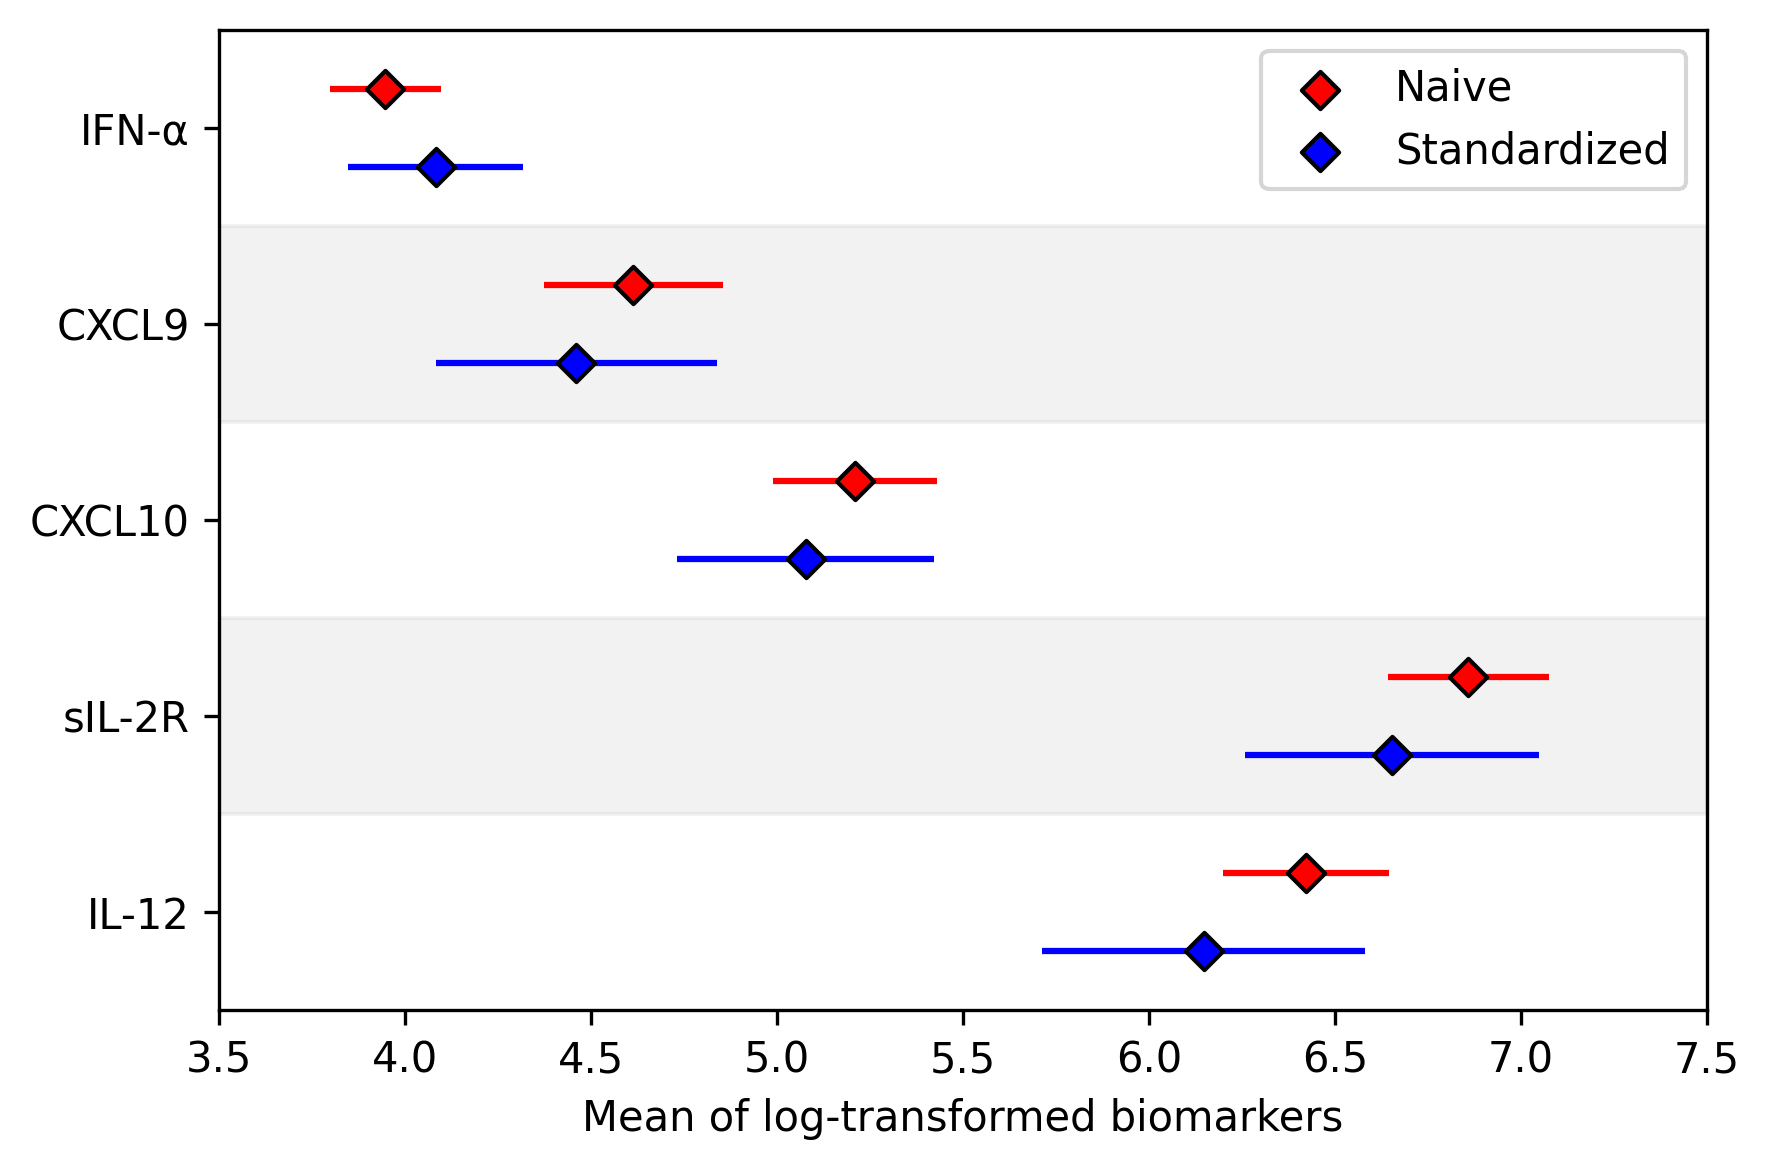

In [13]:
# Displaying results
plt.figure(figsize=[6, 4])

# Plotting point estimates
plt.scatter(nm.theta, [i-0.2 for i in range(len(biomarkers))],
            s=40, color='red', edgecolors='k', marker='D', 
            zorder=3, label='Naive')
plt.scatter(wm.theta[2:], [i+0.2 for i in range(len(biomarkers))],
            s=40, color='blue', edgecolors='k', marker='D', 
            zorder=3, label='Standardized')

# Plotting confidence intervals
plt.hlines([i-0.2 for i in range(len(biomarkers))],
           nm.theta - 1.96*np.diag(nm.variance)**0.5,
           nm.theta + 1.96 * np.diag(nm.variance)**0.5,
           colors='red')
plt.hlines([i+0.2 for i in range(len(biomarkers))],
           wm.theta[2:] - 1.96*np.diag(wm.variance)[2:]**0.5,
           wm.theta[2:] + 1.96 * np.diag(wm.variance)[2:]**0.5,
           colors='blue')

# Some shaded regions to make it easier to examine
plt.fill_between([3, 7.5], [3.5, 3.5], [2.5, 2.5], color='gray', alpha=0.1)
plt.fill_between([3, 7.5], [1.5, 1.5], [0.5, 0.5], color='gray', alpha=0.1)

plt.yticks([i for i in range(len(biomarkers))],
           ['IFN-α', 'CXCL9', 'CXCL10', 'sIL-2R', 'IL-12'])
plt.ylim([4.5, -0.5])
plt.xlim([3.5, 7.5])
plt.xlabel("Mean of log-transformed biomarkers")
plt.legend()
plt.tight_layout()

As shown here, there are some differences in biomarkers after standardizing the data (particularly IL-12 and sIL-2R).

This concludes the examples provided in the paper.

### References

Ritz, C., Baty, F., Streibig, J. C. & Gerhard, D. Dose-Response Analysis Using R. PLOS ONE 10, e0146021 (2015).

Inderjit, Streibig, J. C. & Olofsdotter, M. Joint action of phenolic acid mixtures and its significance in allelopathy research. Physiol Plant 114, 422–428 (2002).

Kamat, A. et al. A Plasma Biomarker Signature of Immune Activation in HIV Patients on Antiretroviral Therapy. PLOS ONE 7, e30881 (2012).